Fetching all S&P 500 tickers...
Number of tickers: 501


C:\Users\bw391\AppData\Local\Temp\ipykernel_74956\2890263069.py:70: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  close_df = close_df.fillna(method='ffill').fillna(method='bfill')


Number of tickers with nearly full 3-year data: 501

Performing normality test on log-returns for all stocks...
Top 5 stocks closest to normal distribution:
    Ticker  Shapiro_p    n
154    DUK   0.004437  751
417     SO   0.000261  751
371    PNW   0.000090  751
375    PPL   0.000019  751
87    CBOE   0.000015  751
Bottom 5 stocks furthest from normal distribution:
    Ticker     Shapiro_p    n
239    HII  1.156490e-35  751
487    WST  6.154504e-36  751
281     LW  4.349722e-36  751
414     SW  1.842873e-37  751
216     GL  2.198258e-45  751
Displaying: DUK  p=0.004437


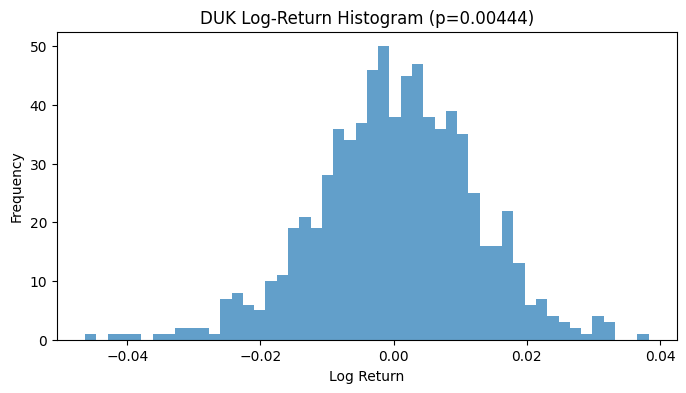

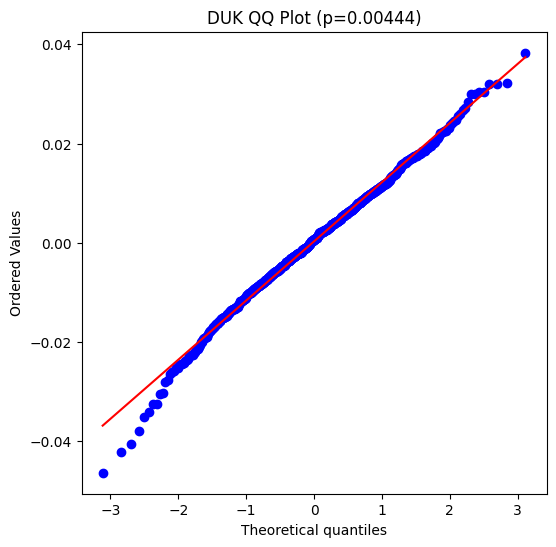

Displaying: SO  p=0.0002606


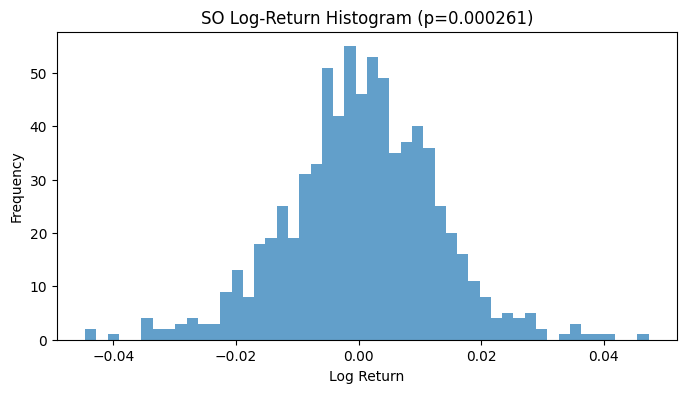

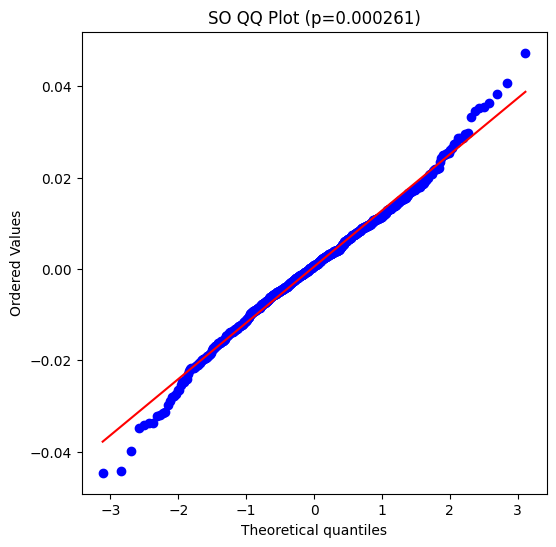

Displaying: PNW  p=8.976e-05


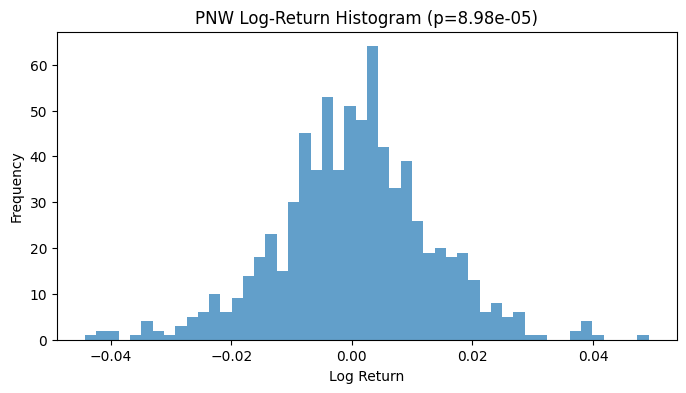

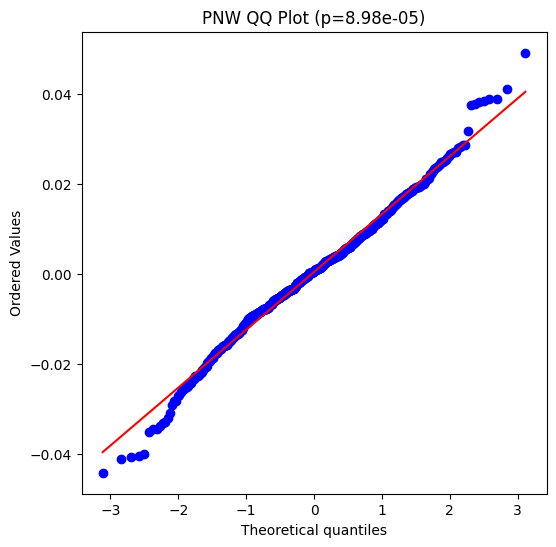

Displaying: LW  p=4.35e-36


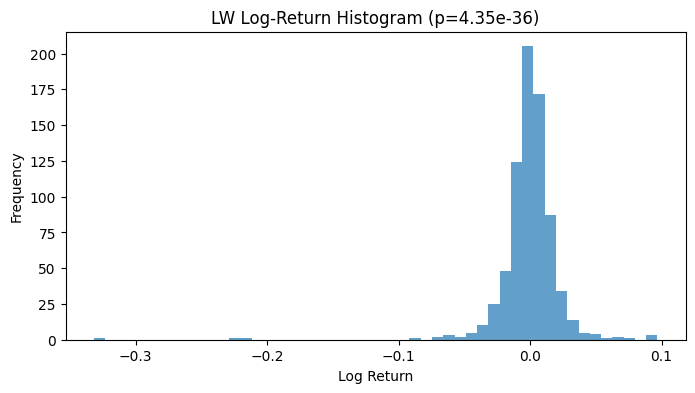

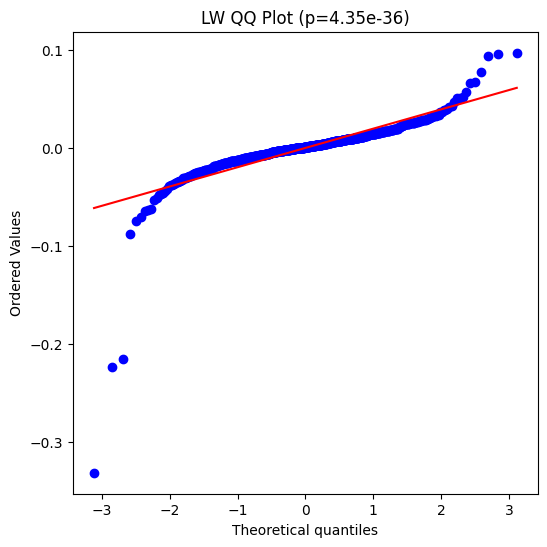

Displaying: SW  p=1.843e-37


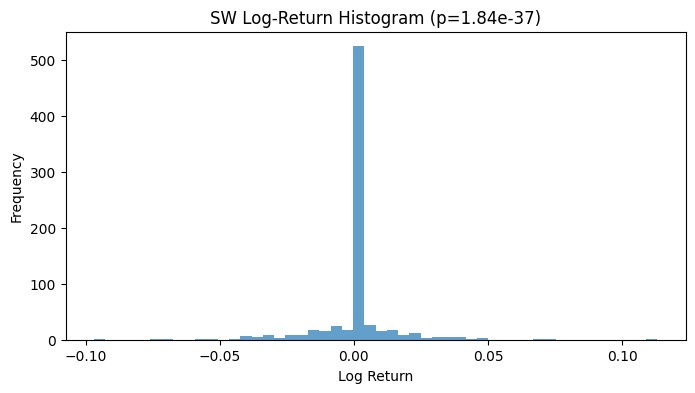

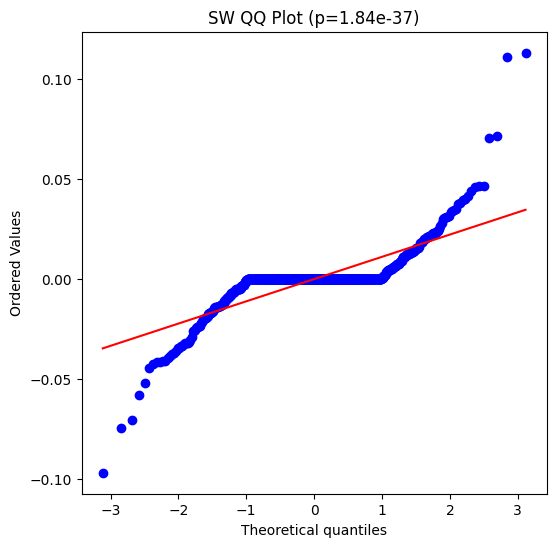

Displaying: GL  p=2.198e-45


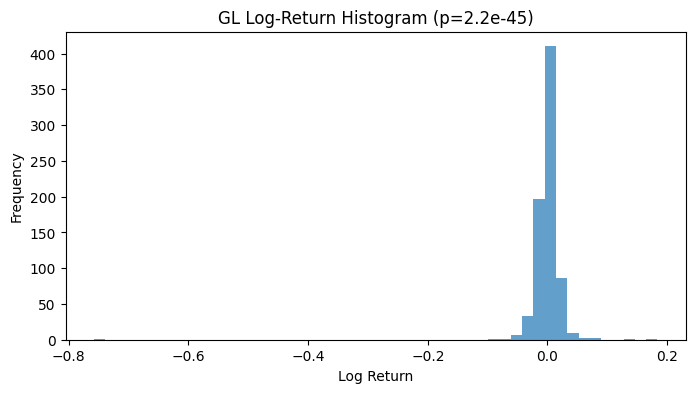

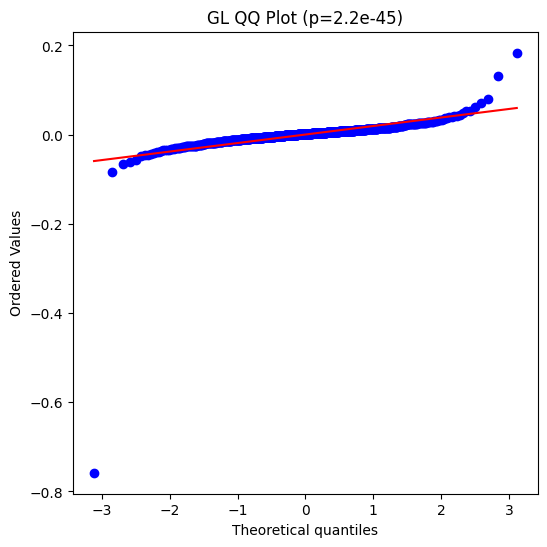

Indices of top 5 most normal: [154, 417, 371, 375, 87]
Indices of bottom 5 least normal: [239, 487, 281, 414, 216]


In [14]:
import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random
from tqdm import tqdm
import scipy
from scipy.stats import shapiro
import scipy.stats as stats



def test_normality_all(log_returns):
    """
    Apply Shapiro-Wilk normality test to log-returns of all stocks.
    Returns a DataFrame sorted by p-value (descending).
    """
    results = []
    for t in log_returns.columns:
        series = log_returns[t].dropna()
        if len(series) < 50:  # Skip stocks with too little data
            continue
        stat, p = shapiro(series)
        results.append({'Ticker': t, 'Shapiro_p': p, 'n': len(series)})
    results_df = pd.DataFrame(results).sort_values('Shapiro_p', ascending=False)
    return results_df

def plot_stock_distribution(log_returns, ticker, p_value):
    series = log_returns[ticker].dropna()
    # Histogram
    plt.figure(figsize=(8,4))
    plt.hist(series, bins=50, alpha=0.7)
    plt.title(f'{ticker} Log-Return Histogram (p={p_value:.3g})')
    plt.xlabel("Log Return")
    plt.ylabel("Frequency")
    plt.show()
    # QQ Plot
    plt.figure(figsize=(6, 6))
    stats.probplot(series, dist="norm", plot=plt)
    plt.title(f'{ticker} QQ Plot (p={p_value:.3g})')
    plt.show()



def get_sp500_tickers():
    url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
    sp500 = pd.read_html(url)[0]
    tickers = sp500['Symbol'].tolist()
    # Remove tickers with '.' which yfinance has trouble with
    tickers.remove("BRK.B")
    tickers.remove("BF.B")
    return tickers

def get_price_data(tickers, years=3):
    end = datetime.today()
    start = end - timedelta(days=years*365)
    data = yf.download(
        tickers=" ".join(tickers),
        start=start.strftime('%Y-%m-%d'),
        end=end.strftime('%Y-%m-%d'),
        group_by='ticker',
        auto_adjust=True,
        threads=True,
        progress=False
    )
    close_df = pd.DataFrame({tic: data[tic]['Close'] for tic in tickers if tic in data.columns})

    # Fill missing values by forward/backward fill for small gaps (e.g. holidays, suspensions)
    close_df = close_df.fillna(method='ffill').fillna(method='bfill')

    # Filter stocks that have data for almost all dates (allow at most 10 missing days)
    min_days = 252 * years - 10
    valid_tickers = [tic for tic in close_df.columns if close_df[tic].count() >= min_days]
    close_df = close_df[valid_tickers]

    return close_df

def calc_portfolio_metrics(close_df, selected_tickers, weights, risk_free_rate=0.04):
    sub_prices = close_df[selected_tickers]
    returns = sub_prices.pct_change().dropna()
    port_returns = returns @ weights
    log_ret = np.log1p(port_returns)
    ann_ret = np.exp(log_ret.mean() * 252) - 1
    ann_vol = port_returns.std() * np.sqrt(252)
    sharpe = (ann_ret - risk_free_rate) / ann_vol if ann_vol != 0 else np.nan
    return ann_ret, ann_vol, sharpe

def sample_weights(N, max_weight=0.1, max_trials=100):
    for _ in range(max_trials):
        w = np.random.dirichlet(np.ones(N), size=1)[0]
        if all(w <= max_weight):
            return w
    # fallback to clipping, then renormalize
    w = np.clip(w, None, max_weight)
    w = w / w.sum()
    return w

def random_portfolio_metrics(close_df, tickers, num_trials=10000, risk_free_rate=0.04):
    all_metrics = []
    N = 20
    for _ in tqdm(range(num_trials), desc="Simulating portfolios"):
        selected = random.sample(tickers, N)
        weights = sample_weights(N, max_weight=0.1)
        try:
            ann_ret, ann_vol, sharpe = calc_portfolio_metrics(close_df, selected, weights, risk_free_rate)
            all_metrics.append([
                ann_ret, ann_vol, sharpe,
                selected,
                list(weights)
            ])
        except Exception as e:
            continue
    return pd.DataFrame(
        all_metrics,
        columns=['Ann_Return','Ann_Volatility','Sharpe','Tickers','Weights']
    )

def plot_metrics(df, title_prefix="Random Portfolio"):
    plt.figure(figsize=(8,5))
    plt.hist(df['Ann_Return'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Annualized Return Distribution')
    plt.xlabel('Annualized Return')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(df['Ann_Volatility'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Annualized Volatility Distribution')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Frequency')
    plt.show()

    plt.figure(figsize=(8,5))
    plt.hist(df['Sharpe'], bins=30, alpha=0.7)
    plt.title(f'{title_prefix} Sharpe Ratio Distribution')
    plt.xlabel('Sharpe Ratio')
    plt.ylabel('Frequency')
    plt.show()

    # Risk-return scatter plot
    plt.figure(figsize=(8,6))
    plt.scatter(df['Ann_Volatility'], df['Ann_Return'], c=df['Sharpe'], cmap='coolwarm', alpha=0.4)
    plt.colorbar(label='Sharpe Ratio')
    plt.xlabel('Annualized Volatility')
    plt.ylabel('Annualized Return')
    plt.title(f'{title_prefix} Volatility vs Return')
    plt.show()

def main():
    print("Fetching all S&P 500 tickers...")
    tickers = get_sp500_tickers()
    print("Number of tickers:", len(tickers))

    print("Downloading all price data...")
    close_df = get_price_data(tickers, years=3)
    print("Number of tickers with nearly full 3-year data:", len(close_df.columns))

    # --- Normality test section ---
    print("\nPerforming normality test on log-returns for all stocks...")
    log_returns = np.log(close_df / close_df.shift(1))
    results_df = test_normality_all(log_returns)

    print("Top 5 stocks closest to normal distribution:")
    print(results_df.head(5)[['Ticker','Shapiro_p','n']])

    print("Bottom 5 stocks furthest from normal distribution:")
    print(results_df.tail(5)[['Ticker','Shapiro_p','n']])

    # Show histograms and QQ plots for the top 3 and bottom 3
    for idx in list(results_df.head(3).index) + list(results_df.tail(3).index):
        ticker = results_df.loc[idx, 'Ticker']
        p_val = results_df.loc[idx, 'Shapiro_p']
        print(f"Displaying: {ticker}  p={p_val:.4g}")
        plot_stock_distribution(log_returns, ticker, p_val)

    print("Indices of top 5 most normal:", results_df.head(5).index.tolist())
    print("Indices of bottom 5 least normal:", results_df.tail(5).index.tolist())

if __name__ == '__main__':
    main()
